# PHASE 3: ADVANCED MODELING & STRATEGIC ACTION

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

# For association rules
from mlxtend.frequent_patterns import apriori, association_rules

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

### - LOAD CLEANED TRANSACTIONS + RFM SEGMENTS

In [2]:
print("Loading cleaned transaction data and RFM segments...")

df = pd.read_csv('online_retail_cleaned.csv')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

rfm = pd.read_csv('rfm_analysis_results.csv')  # from Phase 2
# ensure CustomerID same type
rfm['CustomerID'] = pd.to_numeric(rfm['CustomerID'], errors='coerce').astype('Int64')
df['CustomerID'] = pd.to_numeric(df['CustomerID'], errors='coerce').astype('Int64')

print("Transactions shape:", df.shape)
print("RFM table shape:", rfm.shape)

df.head()

Loading cleaned transaction data and RFM segments...
Transactions shape: (522569, 16)
RFM table shape: (4334, 6)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,Year,Month,Day,DayOfWeek,Hour,Quarter,DayName
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010,12,1,2,8,4,Wednesday
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,1,2,8,4,Wednesday
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010,12,1,2,8,4,Wednesday
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,1,2,8,4,Wednesday
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,1,2,8,4,Wednesday


## ASSOCIATION RULES (MARKET BASKET ANALYSIS)

Methodology 1: Association Rules (Support, Confidence, Lift)

In [3]:
print("\n=== Association Rules (Market Basket Analysis) ===")

# Focus on United Kingdom transactions (main market)
basket_df = df[df['Country'] == 'United Kingdom'].copy()

# Drop missing InvoiceNo / StockCode just in case
basket_df = basket_df.dropna(subset=['InvoiceNo', 'StockCode'])

# Build Invoice x Product matrix with quantities
basket_pivot = (
    basket_df
    .groupby(['InvoiceNo', 'StockCode'])['Quantity']
    .sum()
    .unstack(fill_value=0)
)

# Optional: keep only reasonably frequent products to avoid explosion
product_counts = (basket_pivot > 0).sum(axis=0)
basket_pivot = basket_pivot.loc[:, product_counts >= 50]  # appear in at least 50 invoices

# Convert to boolean presence/absence (required by apriori)
basket_bool = basket_pivot.gt(0)

print("Basket matrix shape (Invoices x Products):", basket_bool.shape)

# Run Apriori
frequent_itemsets = apriori(
    basket_bool,
    min_support=0.01,      # tune as needed
    use_colnames=True
)

print("Frequent itemsets found:", len(frequent_itemsets))

# Generate association rules
rules = association_rules(
    frequent_itemsets,
    metric="confidence",
    min_threshold=0.3      # tune as needed
)

# Keep interesting rules (lift > 1)
rules = rules[rules['lift'] > 1].sort_values(by='lift', ascending=False)

print("Association rules after filtering (lift > 1):", rules.shape[0])

# Show top rules
rules_display = rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10)
display(rules_display)



=== Association Rules (Market Basket Analysis) ===
Basket matrix shape (Invoices x Products): (17901, 2102)
Frequent itemsets found: 2211
Association rules after filtering (lift > 1): 2398


,antecedents,consequents,support,confidence,lift
2352,"(22919, 22916)","(22918, 22917)",0.010055,0.900000,77.830435
2351,"(22918, 22917)","(22919, 22916)",0.010055,0.869565,77.830435
2366,"(22920, 22916)","(22918, 22917)",0.010055,0.886700,76.680231
2365,"(22918, 22917)","(22920, 22916)",0.010055,0.869565,76.680231
2353,"(22919, 22917)","(22918, 22916)",0.010055,0.878049,75.932131
2350,"(22918, 22916)","(22919, 22917)",0.010055,0.869565,75.932131
2364,"(22918, 22916)","(22920, 22917)",0.010055,0.869565,75.563529
2367,"(22920, 22917)","(22918, 22916)",0.010055,0.873786,75.563529
2360,"(22918, 22920, 22917)",(22916),0.010055,0.962567,74.916996
2371,(22916),"(22918, 22920, 22917)",0.010055,0.782609,74.916996


### - Simple item-based recommender from rules

In [4]:
def recommend_from_item(stock_code: str, top_n: int = 5) -> pd.DataFrame:
    """
    Given a StockCode, return top_n associated products
    based on rules (sorted by lift, then confidence).
    """
    mask = rules['antecedents'].apply(lambda s: stock_code in list(s))
    subset = rules[mask].copy()
    
    if subset.empty:
        print(f"No strong rules found for item {stock_code}.")
        return pd.DataFrame()
    
    subset = subset.sort_values(
        by=['lift', 'confidence', 'support'],
        ascending=False
    )
    
    subset['antecedents_str'] = subset['antecedents'].apply(lambda s: ', '.join(list(s)))
    subset['consequents_str'] = subset['consequents'].apply(lambda s: ', '.join(list(s)))
    
    return subset[['antecedents_str', 'consequents_str', 'support', 'confidence', 'lift']].head(top_n)

# Example: recommendations for a popular item, e.g. "85123A"
example_recs = recommend_from_item('85123A', top_n=5)
display(example_recs)

,antecedents_str,consequents_str,support,confidence,lift
1975,"85123A, 82482",82494L,0.011005,0.538251,10.936706
1973,"82494L, 85123A",82482,0.011005,0.639610,10.640953
1782,"22469, 85123A",22470,0.010558,0.525000,10.282303
1781,"22470, 85123A",22469,0.010558,0.560831,8.624943


# PREDICTIVE MODELING (RANDOM FOREST)

Predict which customers are / will be Loyal Spenders, based on behaviour + RFM.

In [5]:
print("\n=== Predictive Modeling (Random Forest) ===")

# Merge RFM info back to transactions for feature engineering
rfm_small = rfm[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'Segment']].copy()
df_feat = df.merge(rfm_small, on='CustomerID', how='inner')

print("Merged feature table shape:", df_feat.shape)
display(df_feat.head())


=== Predictive Modeling (Random Forest) ===
Merged feature table shape: (391150, 20)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,Year,Month,Day,DayOfWeek,Hour,Quarter,DayName,Recency,Frequency,Monetary,Segment
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010,12,1,2,8,4,Wednesday,372,34,5391.21,Loyal Spenders
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,1,2,8,4,Wednesday,372,34,5391.21,Loyal Spenders
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010,12,1,2,8,4,Wednesday,372,34,5391.21,Loyal Spenders
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,1,2,8,4,Wednesday,372,34,5391.21,Loyal Spenders
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,1,2,8,4,Wednesday,372,34,5391.21,Loyal Spenders


### - Build customer-level features

In [6]:
# 1) Basic aggregates
cust_invoices = df_feat.groupby('CustomerID')['InvoiceNo'].nunique().rename('NumInvoices')
cust_qty = df_feat.groupby('CustomerID')['Quantity'].sum().rename('TotalQuantity')
cust_sales = df_feat.groupby('CustomerID')['Sales'].sum().rename('TotalSales')

features = pd.concat([cust_invoices, cust_qty, cust_sales], axis=1)
features['AvgBasketSize'] = features['TotalQuantity'] / features['NumInvoices']

# 2) Main country per customer
cust_country = (
    df_feat
    .groupby('CustomerID')['Country']
    .agg(lambda x: x.value_counts().idxmax())
    .rename('MainCountry')
)
country_dummies = pd.get_dummies(cust_country, prefix='Country')

# 3) Add RFM numeric features
rfm_numeric = rfm.set_index('CustomerID')[['Recency', 'Frequency', 'Monetary']]

# Combine all
X_all = (
    features
    .join(country_dummies, how='left')
    .join(rfm_numeric, how='left')
)

X_all = X_all.fillna(0)

print("Final feature matrix shape:", X_all.shape)
display(X_all.head())


Final feature matrix shape: (4334, 44)


,NumInvoices,TotalQuantity,TotalSales,AvgBasketSize,Country_Australia,Country_Austria,Country_Bahrain,Country_Belgium,Country_Brazil,Country_Canada,...,Country_Spain,Country_Sweden,Country_Switzerland,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified,Recency,Frequency,Monetary
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346,1,74215,77183.60,74215.000000,False,False,False,False,False,False,...,False,False,False,False,False,True,False,326,1,77183.60
12347,7,2458,4310.00,351.142857,False,False,False,False,False,False,...,False,False,False,False,False,False,False,2,7,4310.00
12348,4,2332,1437.24,583.000000,False,False,False,False,False,False,...,False,False,False,False,False,False,False,75,4,1437.24
12349,1,630,1457.55,630.000000,False,False,False,False,False,False,...,False,False,False,False,False,False,False,19,1,1457.55
12350,1,196,294.40,196.000000,False,False,False,False,False,False,...,False,False,False,False,False,False,False,310,1,294.40


### - TARGET VARIABLE: LOYAL SPENDER OR NOT

In [7]:
segment_map = rfm.set_index('CustomerID')['Segment']
y_all = segment_map.reindex(X_all.index)

# Binary label: 1 = Loyal Spenders, 0 = others
y = (y_all == 'Loyal Spenders').astype(int)

print("Label distribution:")
print(y.value_counts())

Label distribution:
Segment
0    3573
1     761
Name: count, dtype: int64


### - Train–test split and model training

In [8]:
# --------------------------------------------
# TRAIN-TEST SPLIT + SCALING
# --------------------------------------------

X = X_all.copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape[0])
print("Test size :", X_test.shape[0])

# Scale only numeric intensity features (RF doesn't strictly need it, but fine)
numeric_cols = ['NumInvoices', 'TotalQuantity', 'TotalSales', 'AvgBasketSize',
                'Recency', 'Frequency', 'Monetary']

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

# --------------------------------------------
# RANDOM FOREST CLASSIFIER
# --------------------------------------------

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'   # helpful if classes are imbalanced
)

rf.fit(X_train_scaled, y_train)
print("Random Forest model trained.")


Train size: 3033
Test size : 1301
Random Forest model trained.


### - Evaluation: Accuracy, Precision, F1, AUC, Confusion Matrix


=== Model Performance on Test Set ===
Accuracy : 0.9869
Precision: 0.9862
Recall   : 0.9386
F1-Score : 0.9618
AUC      : 0.9989

Classification Report:
               precision    recall  f1-score   support

        Other       0.99      1.00      0.99      1073
Loyal Spender       0.99      0.94      0.96       228

     accuracy                           0.99      1301
    macro avg       0.99      0.97      0.98      1301
 weighted avg       0.99      0.99      0.99      1301



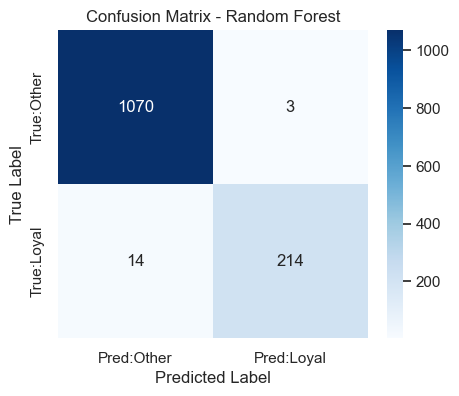

In [9]:
y_pred = rf.predict(X_test_scaled)
y_proba = rf.predict_proba(X_test_scaled)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc = roc_auc_score(y_test, y_proba)

print("\n=== Model Performance on Test Set ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Other', 'Loyal Spender']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred:Other', 'Pred:Loyal'],
            yticklabels=['True:Other', 'True:Loyal'])
plt.title('Confusion Matrix - Random Forest')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### - Sample Customer Predictions

Here are some customers and how our model predicts their loyalty.

In [12]:
label_to_name = {0: "Other", 1: "Loyal Spender"}

pred_named = X_test.copy()
pred_named['TrueSegment'] = y_test.map(label_to_name)

# FIX: Convert numpy array y_pred → pandas Series
y_pred_series = pd.Series(y_pred, index=X_test.index)

pred_named['PredSegment'] = y_pred_series.map(label_to_name)
pred_named['PredProb_Loyal'] = y_proba.round(3)

display(pred_named.sample(10, random_state=1))


,NumInvoices,TotalQuantity,TotalSales,AvgBasketSize,Country_Australia,Country_Austria,Country_Bahrain,Country_Belgium,Country_Brazil,Country_Canada,...,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified,Recency,Frequency,Monetary,TrueSegment,PredSegment,PredProb_Loyal
CustomerID,,,,,,,,,,,,,,,,,,,,,
12560,2,1098,1918.01,549.000000,False,False,False,False,False,False,...,False,False,False,False,5,2,1918.01,Other,Other,0.095
17158,3,778,1266.97,259.333333,False,False,False,False,False,False,...,False,False,True,False,32,3,1266.97,Other,Other,0.010
14842,4,1166,2824.69,291.500000,False,False,False,False,False,False,...,False,False,True,False,44,4,2824.69,Other,Other,0.005
13162,4,1713,1688.29,428.250000,False,False,False,False,False,False,...,False,False,True,False,122,4,1688.29,Other,Other,0.000
15634,1,99,243.55,99.000000,False,False,False,False,False,False,...,False,False,True,False,17,1,243.55,Other,Other,0.000
12576,5,967,1315.83,193.400000,False,False,False,False,False,False,...,False,False,False,False,36,5,1315.83,Other,Other,0.080
14497,1,235,475.37,235.000000,False,False,False,False,False,False,...,False,False,True,False,309,1,475.37,Other,Other,0.000
17419,12,1876,4226.57,156.333333,False,False,False,False,False,False,...,False,False,True,False,11,12,4226.57,Loyal Spender,Loyal Spender,0.990
13769,10,1163,2796.51,116.300000,False,False,False,False,False,False,...,False,False,True,False,2,10,2796.51,Loyal Spender,Loyal Spender,0.975


### - Top N customers most likely to become Loyal Spenders

In [13]:
pred_df = X_test.copy()
pred_df['PredProb_Loyal'] = y_proba

top_candidates = pred_df.sort_values(by='PredProb_Loyal', ascending=False).head(10)
display(top_candidates)

,NumInvoices,TotalQuantity,TotalSales,AvgBasketSize,Country_Australia,Country_Austria,Country_Bahrain,Country_Belgium,Country_Brazil,Country_Canada,...,Country_Sweden,Country_Switzerland,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified,Recency,Frequency,Monetary,PredProb_Loyal
CustomerID,,,,,,,,,,,,,,,,,,,,,
14299,9,2149,3965.62,238.777778,False,False,False,False,False,False,...,False,False,False,False,True,False,8,9,3965.62,1.0
17428,28,9474,17256.85,338.357143,False,False,False,False,False,False,...,False,False,False,False,True,False,1,28,17256.85,1.0
14051,23,3756,15610.39,163.304348,False,False,False,False,False,False,...,False,False,False,False,True,False,1,23,15610.39,1.0
14056,23,4252,8152.71,184.869565,False,False,False,False,False,False,...,False,False,False,False,True,False,1,23,8152.71,1.0
15298,12,3116,4799.90,259.666667,False,False,False,False,False,False,...,False,False,False,False,True,False,2,12,4799.90,1.0
13871,13,2806,6403.25,215.846154,False,False,False,False,False,False,...,False,False,False,False,True,False,23,13,6403.25,1.0
15570,12,2063,4148.82,171.916667,False,False,False,False,False,False,...,False,False,False,False,True,False,7,12,4148.82,1.0
13468,37,2589,5704.97,69.972973,False,False,False,False,False,False,...,False,False,False,False,True,False,2,37,5704.97,1.0
17049,9,2673,5655.03,297.000000,False,False,False,False,False,False,...,False,False,False,False,True,False,3,9,5655.03,1.0
